In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
from scipy.optimize import curve_fit

In [2]:
corr = 0.25

# Load Meta-RL results

In [5]:

engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
if corr == 0.25:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0.2_initseed0_batch512"
elif corr == 0.:
    model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_initseed4_batch512"
else:
    raise ValueError(f"Unknown correlation value: {corr}")
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
path_to_pkl = os.path.join(model_path, 'eval_results_offline.pkl')


In [6]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
metarl_df = pd.DataFrame(data)
metarl_df.head()

,model,return,environment,experienced_reward,context_length,path_length_scaled,returns_scaled
1,Learner (temp=2),0.0,0,0,0,1.0,0.0
2,Learner (temp=1),0.0,0,0,0,1.0,0.0
3,Learner (greedy),0.0,0,0,0,1.0,0.0
5,Learner (temp=2),0.0,0,0,25,1.0,0.0
6,Learner (temp=1),0.0,0,0,25,1.0,0.0


# Load DQN results

In [7]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "dqn_cntree"
env_name = "cntree_layers7_bprob1.0_corr0.25_state_dim10_envs1000_H1600_explore"
model_name = "dqn_nlayers4_gamma0.9_target10_lr1e-05_temp0.1"
path_to_pkl = os.path.join(engram_dir, wandb_project, env_name, "models", model_name, "eval_results.pkl")

In [8]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
dqn_df = pd.DataFrame(data)
dqn_df = dqn_df.rename(columns={'returns': 'return'})
dqn_df['model'] = 'DQN'
opt_return = 389.1792
dqn_df['path_length_scaled'] = (opt_return - dqn_df['return'])/opt_return
dqn_df['returns_scaled'] = dqn_df['return']/opt_return
dqn_df.head()

,return,environment,experienced_reward,context_length,model,path_length_scaled,returns_scaled
0,0.0,0,0,10,DQN,1.000000,0.000000
1,0.8,0,0,25,DQN,0.997944,0.002056
2,3.4,0,0,50,DQN,0.991264,0.008736
3,3.7,0,0,75,DQN,0.990493,0.009507
4,3.0,0,0,100,DQN,0.992291,0.007709


# Load Q table results

In [9]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "dqn_cntree"
env_name = "cntree_layers7_bprob1.0_corr0.25_state_dim10_envs1000_H1600_explore"
model_name = "q_table_gamma0.85_temp0.01"
path_to_pkl = os.path.join(engram_dir, wandb_project, env_name, "models", model_name, "eval_results.pkl")

In [10]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
qtable_df = pd.DataFrame(data)
qtable_df = qtable_df.rename(columns={'returns': 'return'})
qtable_df['model'] = 'Q Table'
opt_return = 389.1792
qtable_df['path_length_scaled'] = (opt_return - qtable_df['return'])/opt_return
qtable_df['returns_scaled'] = qtable_df['return']/opt_return
qtable_df.head()

,return,environment,experienced_reward,context_length,model,path_length_scaled,returns_scaled
0,0.7,0,0,10,Q Table,0.998201,0.001799
1,1.2,0,0,25,Q Table,0.996917,0.003083
2,4.3,0,0,50,Q Table,0.988951,0.011049
3,3.1,0,0,75,Q Table,0.992035,0.007965
4,0.7,0,0,100,Q Table,0.998201,0.001799


# Plot all results

In [11]:
# Concatenate the dataframes
df = pd.concat([metarl_df, dqn_df, qtable_df], ignore_index=True)


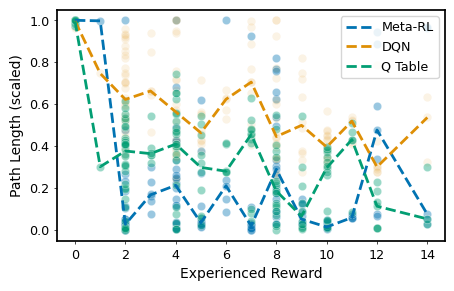

In [12]:

def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

rlim = 15
_df = df[df['experienced_reward'] < rlim]

fig, ax = plt.subplots(figsize=(5,3))
for model, model_name in zip(['Learner (temp=1)', 'DQN', 'Q Table'], ['Meta-RL', 'DQN', 'Q Table']):
    __df = _df[_df['model'] == model]
    alpha = 0.1 if model == 'DQN' else 0.4
    sns.scatterplot(
        data=__df, x='experienced_reward', y='path_length_scaled',
        ax=ax, alpha=alpha)
    
    # Group by experienced_reward and get mean path_length_scaled
    x = __df['experienced_reward']
    y = __df['path_length_scaled']
    grouped = __df.groupby('experienced_reward')['path_length_scaled'].median().reset_index()
    mean_x = grouped['experienced_reward']
    mean_y = grouped['path_length_scaled']
    
    popt, _ = curve_fit(exp_func, x, y, p0=[1, 1e-3, 0])
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = exp_func(x_fit, *popt)
    #ax.plot(x_fit, y_fit, '--', label=model_name, linewidth=2)
    ax.plot(mean_x, mean_y, '--', label=model_name, linewidth=2)
ax.legend()
plt.xlabel('Experienced Reward')
plt.ylabel('Path Length (scaled)')
plt.show()


In [13]:
df['model'].unique()

array(['Learner (temp=2)', 'Learner (temp=1)', 'Learner (greedy)', 'DQN',
       'Q Table'], dtype=object)

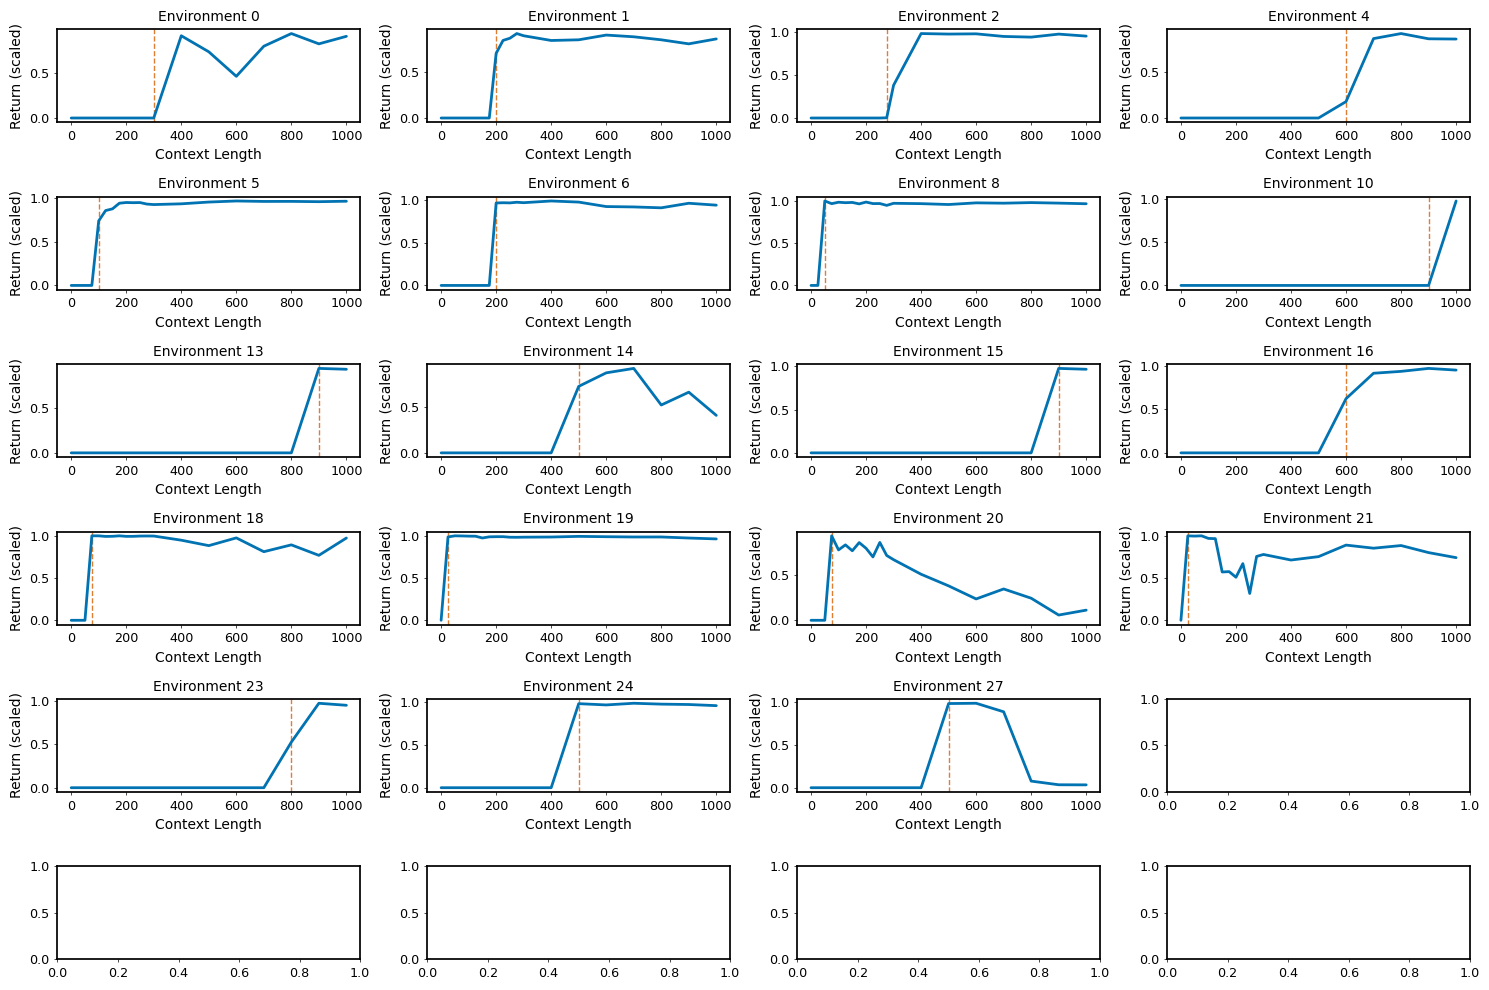

In [14]:
rlim = 30
_df = df[df['model'] == 'Learner (temp=1)']
_df = _df[_df['context_length'] <= 1000]
sample_envs = _df['environment'].unique()

# Create 3x4 subplot grid
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()
n_envs_plotted = 0
n_envs_total = n_rows * n_cols
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    if pd.notna(first_reward) and first_reward < 1000:
        axes[n_envs_plotted].axvline(x=first_reward, color='r', linestyle='--', alpha=0.8)
    else:
        continue
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='returns_scaled',
        ax=axes[n_envs_plotted],
        linewidth=2
    )
    axes[n_envs_plotted].set_title(f'Environment {env}')
    axes[n_envs_plotted].set_xlabel('Context Length')
    axes[n_envs_plotted].set_ylabel('Return (scaled)')

    n_envs_plotted += 1
    if n_envs_plotted == n_envs_total:
        break

plt.tight_layout()
plt.show()


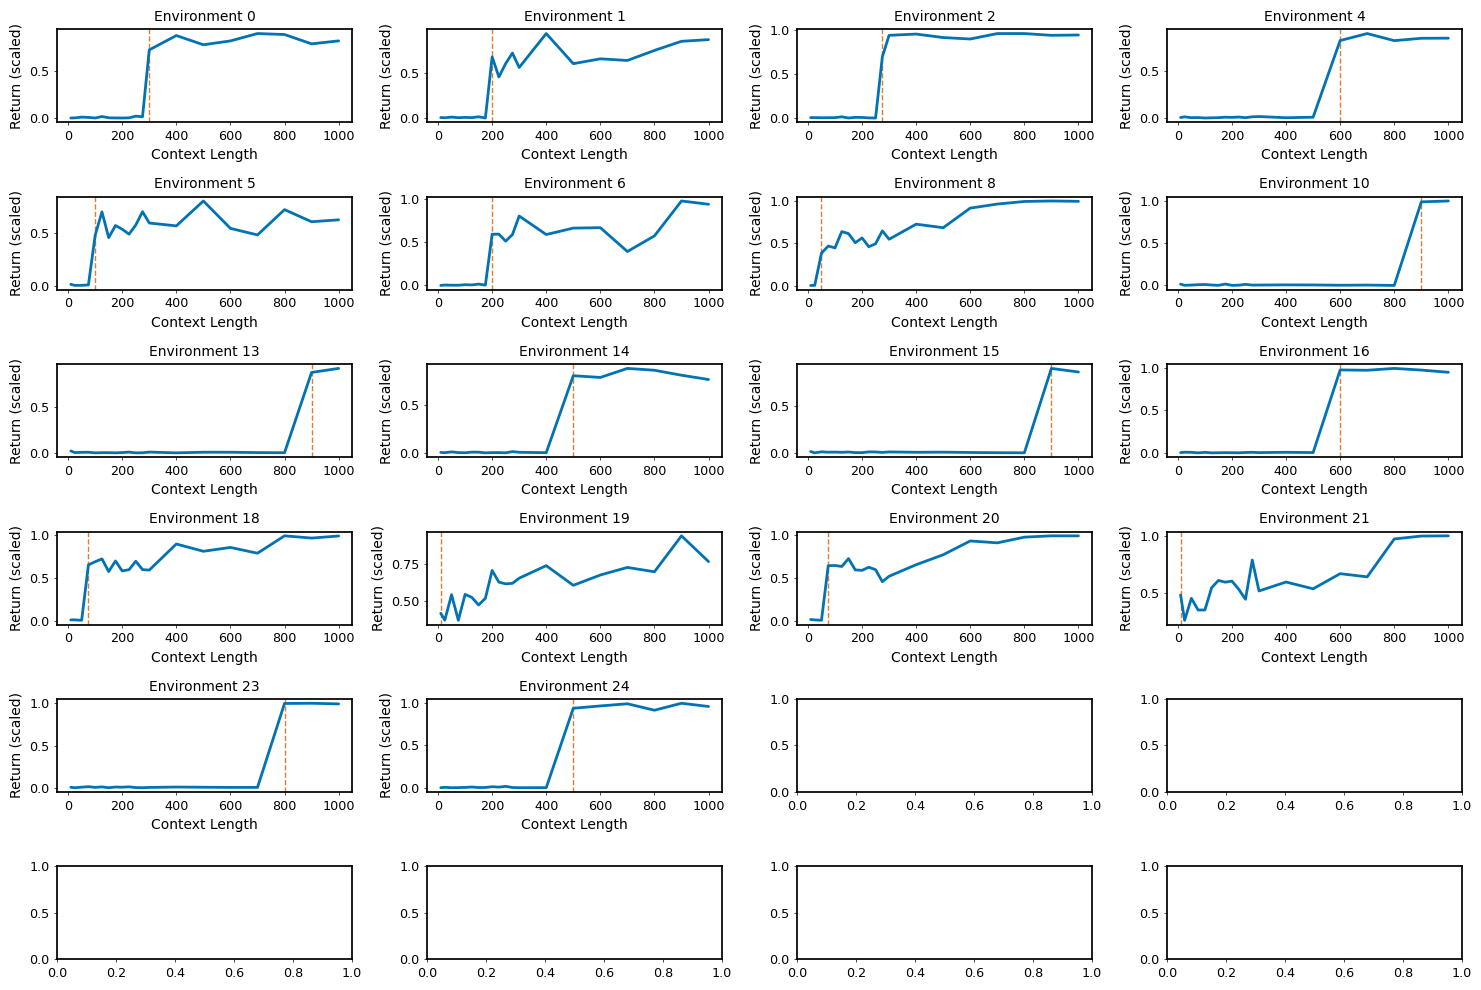

In [15]:
rlim = 30
_df = df[df['model'] == 'Q Table']
_df = _df[_df['context_length'] <= 1000]
sample_envs = _df['environment'].unique()

# Create 3x4 subplot grid
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()
n_envs_plotted = 0
n_envs_total = n_rows * n_cols
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    if pd.notna(first_reward) and first_reward < 1000:
        axes[n_envs_plotted].axvline(x=first_reward, color='r', linestyle='--', alpha=0.8)
    else:
        continue
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='returns_scaled',
        ax=axes[n_envs_plotted],
        linewidth=2
    )
    axes[n_envs_plotted].set_title(f'Environment {env}')
    axes[n_envs_plotted].set_xlabel('Context Length')
    axes[n_envs_plotted].set_ylabel('Return (scaled)')

    n_envs_plotted += 1
    if n_envs_plotted == n_envs_total:
        break

plt.tight_layout()
plt.show()